# Activity: Trying out your own RFM Analysis

Replicate the RFM analysis steps, but only for hours 12PM-5PM.

Kindly fill the code cells with python lines to accomplish the tasks. You may refer to the lecture notebook.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Mount GDrive's folders
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# This code imports a library "os" that allows file navigation
import os
# This code sets the home directory
# Find your folder and put the path here as a string
path = '/content/drive/MyDrive/my_workspace'
os.chdir(path)

## Prepare data

Read csv

In [4]:
df = pd.read_csv("Data/cc_clean.csv")
# df.head()

*Trick*: Pandas has its own methods for dates. We just need to convert it using `pd.to_datetime`.

In [5]:
df['trans_datetime'] = pd.to_datetime(df['trans_datetime'])
df['dob'] = pd.to_datetime(df['dob'], format = "%d/%m/%Y")
# df.head()

For recency analysis, we need to know how much days have passed since the transaction, assuming current date is Jan 1, 2022.

In [6]:
# Define the current date
current_date = pd.to_datetime('2022-01-01  00:00:00')

# Calculate the elapsed days
df['elapsed_days'] = (current_date - df['trans_datetime']).dt.days
# Calculate age
df['age'] = (current_date - df['dob']).dt.days//365



In [7]:
df['age_group'] = df['age'].map(lambda x:  "Middle-aged" if x <= 59 else
                                             "Pre-Retirees" if x <69 else
                                             "Young Seniors" if x <79 else
                                              "Older Seniors")

In [8]:
df['time_of_day'] = df['trans_datetime'].dt.hour
df['time_of_day'] = df['time_of_day'].map(lambda x: "morning" if (x >= 5 and x<12) else
                                                    "afternoon" if (x >= 12 and x < 17) else
                                                    "evening" if (x >= 17 and x < 21) else
                                                    "night")
df['time_of_day'].value_counts

<bound method IndexOpsMixin.value_counts of 0        afternoon
1        afternoon
2        afternoon
3            night
4        afternoon
           ...    
99995        night
99996      morning
99997        night
99998        night
99999      evening
Name: time_of_day, Length: 100000, dtype: object>

In [9]:
df['season'] = df['trans_datetime'].dt.month
df['season'] = df['season'].map(lambda x: "Spring" if (x >= 3 and x<6) else
                                                    "Summer" if (x >= 6 and x < 9) else
                                                    "Fall" if (x >= 9 and x < 12) else
                                                    "Winter")
#df.head()

# df['season'].value_counts()
df.head()

,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt,trans_datetime,elapsed_days,age,age_group,time_of_day,season
0,6.760000e+11,M,Dasmarinas,659019,Chartered loss adjuster,1958-12-12,798000000000,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,68.88,2020-02-10 13:53:31,690,63,Pre-Retirees,afternoon,Winter
1,3.520000e+15,M,Digos,169393,"Administrator, charities/voluntary organisations",1970-08-31,968000000000,968000000000,060d12f91c13871a13963041736a4702,1590902968,entertainment,50.06,2020-05-31 13:29:28,579,51,Middle-aged,afternoon,Spring
2,4.140000e+18,M,Calapan,133893,Financial controller,1953-07-23,628000000000,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,105.44,2020-03-29 13:52:37,642,68,Pre-Retirees,afternoon,Spring
3,4.870000e+15,M,San Fernando,121812,NaN,1964-07-18,863000000000,863000000000,45bbe714e51ab8a375454d39a190b0cb,1613063704,food_dining,38.61,2021-02-12 01:15:04,322,57,Middle-aged,night,Winter
4,4.720000e+15,M,Laoag,111125,Dance movement psychotherapist,1954-01-11,257000000000,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,82.69,2020-09-28 16:35:59,459,68,Pre-Retirees,afternoon,Fall


## Set Variables

In [10]:
segment = 'time_of_day'
# segment = 'age_group'
# segment = 'season'

segment_display = 'Time of Day'
# segment_display = 'Age Group'
# segment_display = 'Season'

segment_sort =  ["morning", "afternoon", "evening", "night"]
# segment_sort =  ["Middle-aged", "Pre-Retirees", "Young Seniors", "Older Seniors"]
# segment_sort =  ["Winter", "Spring" "Summer", "Fall"]

#dimension of figure ## If segment has 4 elemens then (2 by 2)
w = 2
h = 2


def score_level(x):
  if x == 1:
    return 'Low'
  elif x == 2 :
    return 'Middle'
  else:
    return 'Top'


def color(score_level):
  if score_level == "Low":
    return '#d63f38'
  elif score_level == "Middle" :
    return '#cc5f21'
  else:
    return '#67a353'


# def color(x):
#   if x <= 5:
#     return 'Blue'
#   else:
#     return 'Gray'


In [11]:
data_path = f'{path}/Data/{segment}'
if not os.path.exists(data_path):
    os.makedirs(data_path)

segment_sort_df = pd.DataFrame(segment_sort, columns=[segment])
segment_sort_df['sort'] = segment_sort_df.index
segment_sort_df

rfm_group_by = [segment,'category']



## Overview Segment

In [12]:
segment_summary_df= df.groupby([segment])['amt'].agg(["size","sum", "mean"]).reset_index()
segment_recency= df.groupby([segment])['elapsed_days'].min().to_frame('recency').reset_index()
segment_summary_df.columns = [segment, 'frequency', 'total_amount', 'average_amount']
segment_summary_df = pd.merge(segment_recency,segment_summary_df, on = segment, how = 'left')
segment_summary_df = pd.merge(segment_summary_df, segment_sort_df, on = segment, how = 'left')
segment_summary_df = segment_summary_df.sort_values('sort').reset_index(drop=True)
segment_summary_df = segment_summary_df.drop('sort', axis =1)
segment_summary_df

,time_of_day,recency,frequency,total_amount,average_amount
0,morning,24,30166,2325383.20,77.086230
1,afternoon,25,24868,1680925.94,67.593934
2,evening,25,18208,1258142.58,69.098340
3,night,24,26758,1764752.38,65.952328


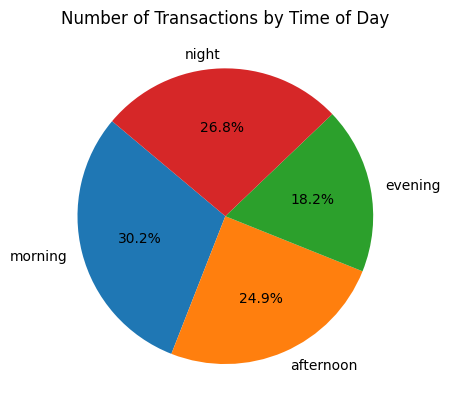

In [13]:
plt.pie(segment_summary_df['frequency'], labels=segment_summary_df[segment], autopct='%1.1f%%', startangle=140)
# plt.axis('equal')
title = f'Number of Transactions by {segment_display}'
plt.title(title)
plt.savefig(f'{data_path}/{title}_Pie.png')
plt.show()

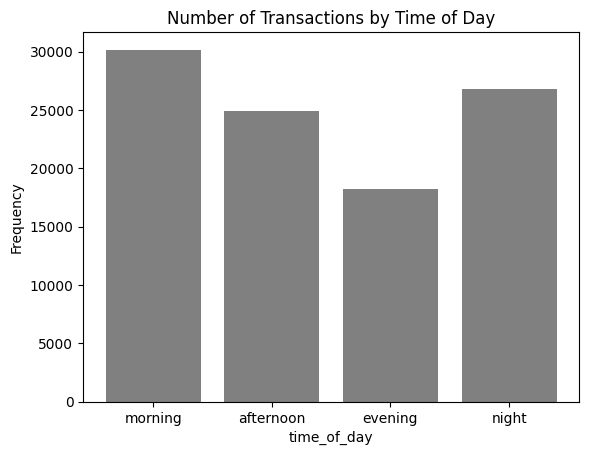

In [14]:
plt.bar(segment_summary_df[segment], segment_summary_df['frequency'], color = "grey")

# Adding labels and title
plt.xlabel(segment)
plt.ylabel('Frequency')
title = f'Number of Transactions by {segment_display}'
plt.title(title)
plt.savefig(f'{data_path}/{title}_Bar.png')
plt.show()

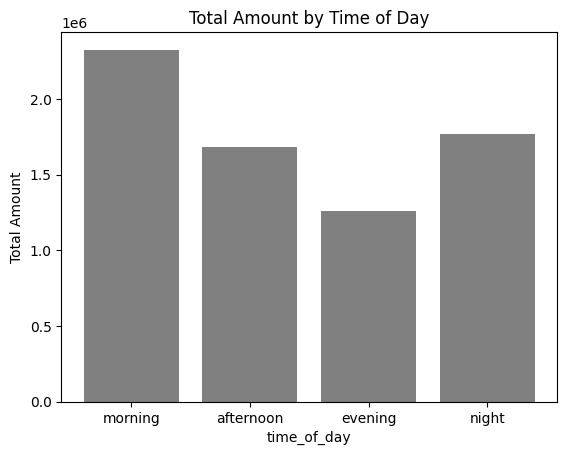

In [15]:
plt.bar(segment_summary_df[segment], segment_summary_df['total_amount'], color = "grey")

# Adding labels and title
plt.xlabel(segment)
plt.ylabel('Total Amount')
title = f'Total Amount by {segment_display}'
plt.title(title)
plt.savefig(f'{data_path}/{title}.png')
plt.show()

Using pandas method `pd.qcut` (quantile cut), classify and score the customers based on their monetary value

**Larger total transaction amts => Higher score**

* 1- low score
* 2- medium score
* 3- high score

## Recency

In [16]:
recency_partition = {
    "time_of_day": [25,30],
    "age_group": [25,26],
    "season": [30,200]
}
def assign_score_recency(x):
  if x < recency_partition[segment][0]:
    return 3
  elif x < recency_partition[segment][1]:
    return 2
  else:
    return 1


In [17]:
rec_df = df.groupby(rfm_group_by)['elapsed_days'].min().to_frame(name='recency').reset_index()

rec_df['recency_score'] = rec_df['recency'].map(assign_score_recency)
rec_df['recency_score_level'] = rec_df['recency_score'].map(score_level)

rec_df = rec_df.sort_values('recency').reset_index(drop = True)
# print(rec_df['recency'].value_counts())
# print(rec_df['recency_score'].value_counts())
rec_top_df = rec_df.nsmallest(1, 'recency', keep='all')
rec_top_df

,time_of_day,category,recency,recency_score,recency_score_level
0,morning,food_dining,24,3,Top
1,night,personal_care,24,3,Top
2,night,kids_pets,24,3,Top
3,night,home,24,3,Top
4,night,health_fitness,24,3,Top
5,night,food_dining,24,3,Top
6,morning,personal_care,24,3,Top
7,morning,kids_pets,24,3,Top
8,morning,home,24,3,Top
9,morning,health_fitness,24,3,Top


<ipython-input-18-a3da4a550e9f>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[posx, posy].set_xticklabels(rec_segment_top_df['category'], rotation=90, ha='right', rotation_mode='anchor')
<ipython-input-18-a3da4a550e9f>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[posx, posy].set_xticklabels(rec_segment_top_df['category'], rotation=90, ha='right', rotation_mode='anchor')
<ipython-input-18-a3da4a550e9f>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[posx, posy].set_xticklabels(rec_segment_top_df['category'], rotation=90, ha='right', rotation_mode='anchor')
<ipython-input-18-a3da4a550e9f>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[posx, posy].set_xticklabels(rec_segment_top_df['category'], rotation=90, ha='right', rotation_mode='anchor')


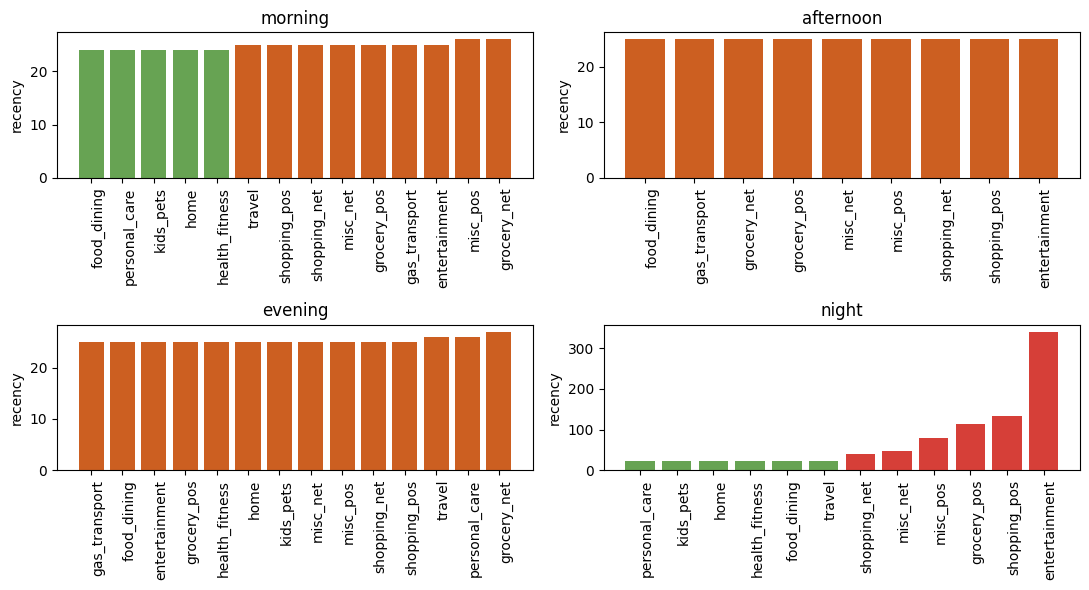

In [18]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(w, h , figsize=(11, 6))

# Combine all the operations and display
for idx,s in enumerate(segment_sort):
  posx = idx // h
  posy = idx % h

  rec_segment_df = rec_df[rec_df[segment] == s]
  rec_segment_top_df = rec_segment_df.reset_index()#rec_segment_df.nlargest(10, 'recency', keep='all')
  rec_segment_top_df['recency'] = rec_segment_top_df['recency'].fillna(0)
  rec_segment_top_df['color'] = rec_segment_top_df['recency_score_level'].map(color)


  axis[posx, posy].bar(rec_segment_top_df['category'],rec_segment_top_df['recency'], color = rec_segment_top_df['color'])
  # axis[posx, posy].set_xticks(rotation=90)
  # title = f"recency by Category and {segment_display} on {s}"
  axis[posx, posy].set_title(s)
  axis[posx, posy].set_xticklabels(rec_segment_top_df['category'], rotation=90, ha='right', rotation_mode='anchor')
  axis[posx, posy].set_ylabel("recency")


plt.tight_layout()
plt.savefig(f'{data_path}/Recency by Category and  {segment_display}.png')
plt.show()

## Frequency

In [19]:
freq_df = df.groupby(rfm_group_by).size().to_frame(name='frequency').reset_index()
freq_df['frequency_score'] = pd.qcut(freq_df['frequency'], q=3, labels=[1, 2, 3]).astype(int)
freq_df = freq_df.sort_values('frequency', ascending =False).reset_index(drop = True)
freq_df['frequency_score_level'] = freq_df['frequency_score'].map(score_level)

freq_df['frequency_score'].value_counts()

freq_top_df = freq_df.nlargest(5, 'frequency', keep='all')
freq_top_df

,time_of_day,category,frequency,frequency_score,frequency_score_level
0,night,home,6137,3,Top
1,night,kids_pets,6116,3,Top
2,night,personal_care,4998,3,Top
3,afternoon,shopping_pos,3914,3,Top
4,afternoon,gas_transport,3910,3,Top


<ipython-input-20-2bc77570b382>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[posx, posy].set_xticklabels(freq_segment_top_df['category'], rotation=90, ha='right', rotation_mode='anchor')
<ipython-input-20-2bc77570b382>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[posx, posy].set_xticklabels(freq_segment_top_df['category'], rotation=90, ha='right', rotation_mode='anchor')
<ipython-input-20-2bc77570b382>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[posx, posy].set_xticklabels(freq_segment_top_df['category'], rotation=90, ha='right', rotation_mode='anchor')
<ipython-input-20-2bc77570b382>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[posx, posy].set_xticklabels(freq_segment_top_df['category'], rotation=90, ha='right', rotation_mode='anchor')


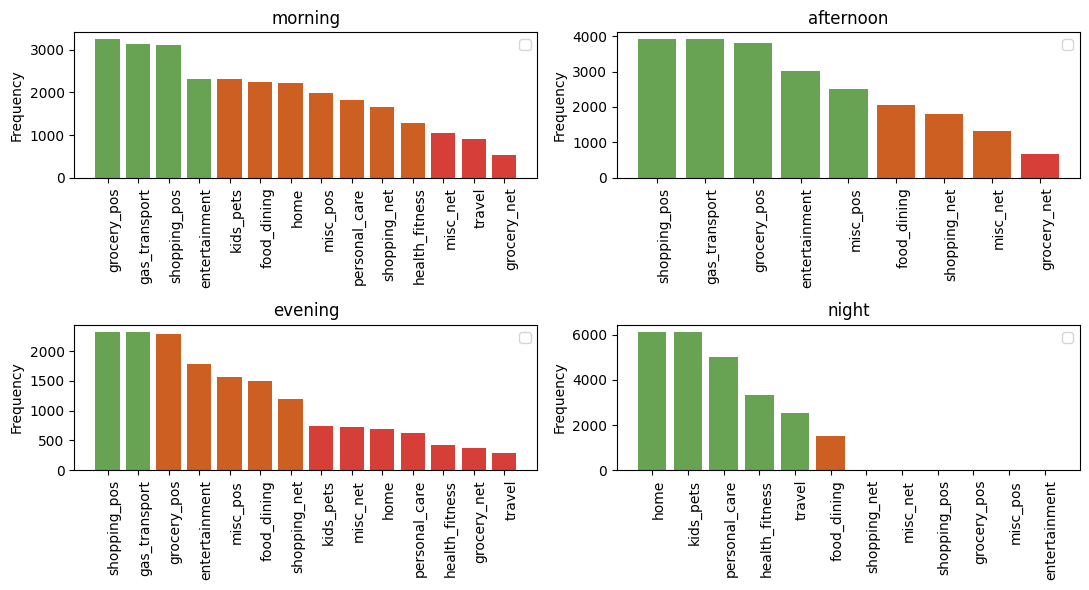

In [20]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2 , figsize=(11, 6))

# Combine all the operations and display
for idx,s in enumerate(segment_sort):
  posx = idx // h
  posy = idx % h

  freq_segment_df = freq_df[freq_df[segment] == s]
  freq_segment_top_df = freq_segment_df.reset_index()#freq_segment_df.nlargest(10, 'frequency', keep='all')
  freq_segment_top_df['frequency'] = freq_segment_top_df['frequency'].fillna(0)
  freq_segment_top_df['color'] = freq_segment_top_df['frequency_score_level'].map(color)


  axis[posx, posy].bar(freq_segment_top_df['category'],freq_segment_top_df['frequency'], color = freq_segment_top_df['color'])
  # axis[posx, posy].set_xticks(rotation=90)
  # title = f"Frequency by Category and {segment_display} on {s}"
  axis[posx, posy].set_title(s)
  axis[posx, posy].set_xticklabels(freq_segment_top_df['category'], rotation=90, ha='right', rotation_mode='anchor')
  axis[posx, posy].set_ylabel("Frequency")
  axis[posx, posy].legend()


plt.tight_layout()
plt.savefig(f'{data_path}/Frequency by Category and  {segment_display}.png')
plt.show()

## Monetary Value

In [21]:
# Get total spending of each customer first
# groupby + trick to convert back to dataframe
mv_df = df.groupby(rfm_group_by)['amt'].sum().to_frame(name='total_amt').reset_index()
mv_df['monetary_score'] = pd.qcut(mv_df['total_amt'], q=3, labels=[1, 2, 3]).astype(int)
mv_df = mv_df.sort_values('total_amt', ascending =False).reset_index(drop = True)
mv_df['monetary_score_level'] = mv_df['monetary_score'].map(score_level)
mv_top_df = mv_df.nlargest(5, 'total_amt', keep='all')
mv_top_df

,time_of_day,category,total_amt,monetary_score,monetary_score_level
0,night,kids_pets,490652.19,3,Top
1,night,home,366201.30,3,Top
2,afternoon,grocery_pos,346968.58,3,Top
3,morning,grocery_pos,327810.74,3,Top
4,morning,shopping_net,287568.80,3,Top


<ipython-input-22-b36434c42054>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[posx, posy].set_xticklabels(mv_segment_top_df['category'], rotation=90, ha='right', rotation_mode='anchor')
<ipython-input-22-b36434c42054>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[posx, posy].set_xticklabels(mv_segment_top_df['category'], rotation=90, ha='right', rotation_mode='anchor')
<ipython-input-22-b36434c42054>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[posx, posy].set_xticklabels(mv_segment_top_df['category'], rotation=90, ha='right', rotation_mode='anchor')
<ipython-input-22-b36434c42054>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[posx, posy].set_xticklabels(mv_segment_top_df['category'], rotation=90, ha='right', rotation_mode='anchor')


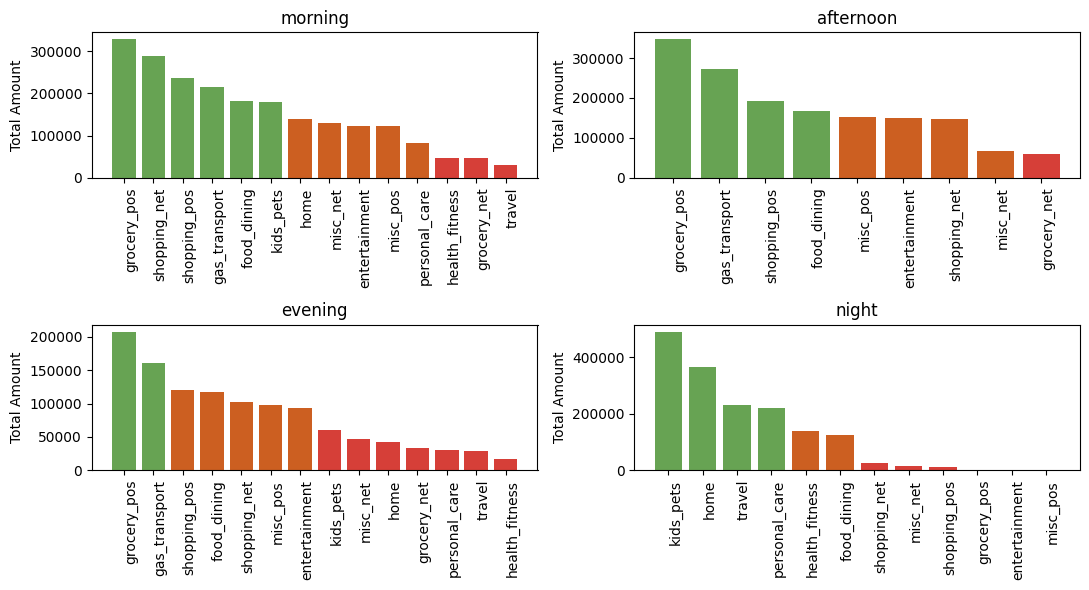

In [22]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2 , figsize=(11, 6))

# Combine all the operations and display
for idx,s in enumerate(segment_sort):
  posx = idx // h
  posy = idx % h

  mv_segment_df = mv_df[mv_df[segment] == s]
  mv_segment_top_df = mv_segment_df.reset_index()#mv_segment_df.nlargest(10, 'monetary', keep='all')
  mv_segment_top_df['monetary'] = mv_segment_top_df['total_amt'].fillna(0)
  mv_segment_top_df['color'] = mv_segment_top_df['monetary_score_level'].map(color)


  axis[posx, posy].bar(mv_segment_top_df['category'],mv_segment_top_df['monetary'], color = mv_segment_top_df['color'])
  # axis[posx, posy].set_xticks(rotation=90)
  # title = f"monetary by Category and {segment_display} on {s}"
  axis[posx, posy].set_title(s)
  axis[posx, posy].set_xticklabels(mv_segment_top_df['category'], rotation=90, ha='right', rotation_mode='anchor')
  axis[posx, posy].set_ylabel("Total Amount")


plt.tight_layout()
plt.savefig(f'{data_path}/Monetary Value by Category and  {segment_display}.png')
plt.show()

## Combine RFM Tables

In [23]:
rfm_df = pd.merge(rec_df, freq_df, on=rfm_group_by, how='inner')
rfm_df = pd.merge(rfm_df, mv_df, on=rfm_group_by, how='inner')
rfm_df = rfm_df.drop(columns=['recency_score_level', 'frequency_score_level','monetary_score_level'])

In [24]:
rfm_df['rfm_score'] = rfm_df['recency_score'] + rfm_df['frequency_score'] +rfm_df['monetary_score']
def assign_rfm_level(x):
    if x >= 8:
        return 'Top'
    elif 5<=x<8:
        return 'Middle'
    else:
        return 'Low'
rfm_df['rfm_level'] = rfm_df['rfm_score'].map(assign_rfm_level)

rfm_df = rfm_df.sort_values(['rfm_score','total_amt','frequency', 'recency'], ascending = [ False, False, False, True]).reset_index(drop = True)
rfm_top_df = rfm_df.nlargest(1, 'rfm_score', keep='all')
rfm_top_df

,time_of_day,category,recency,recency_score,frequency,frequency_score,total_amt,monetary_score,rfm_score,rfm_level
0,night,kids_pets,24,3,6116,3,490652.19,3,9,Top
1,night,home,24,3,6137,3,366201.30,3,9,Top
2,night,travel,24,3,2516,3,230023.25,3,9,Top
3,night,personal_care,24,3,4998,3,220624.94,3,9,Top


<ipython-input-25-82ce3e585bb6>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[posx, posy].set_xticklabels(rfm_segment_top_df['category'], rotation=90, ha='right', rotation_mode='anchor')
<ipython-input-25-82ce3e585bb6>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[posx, posy].set_xticklabels(rfm_segment_top_df['category'], rotation=90, ha='right', rotation_mode='anchor')
<ipython-input-25-82ce3e585bb6>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[posx, posy].set_xticklabels(rfm_segment_top_df['category'], rotation=90, ha='right', rotation_mode='anchor')
<ipython-input-25-82ce3e585bb6>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[posx, posy].set_xticklabels(rfm_segment_top_df['category'], rotation=90, ha='right', rotation_mode='anchor')


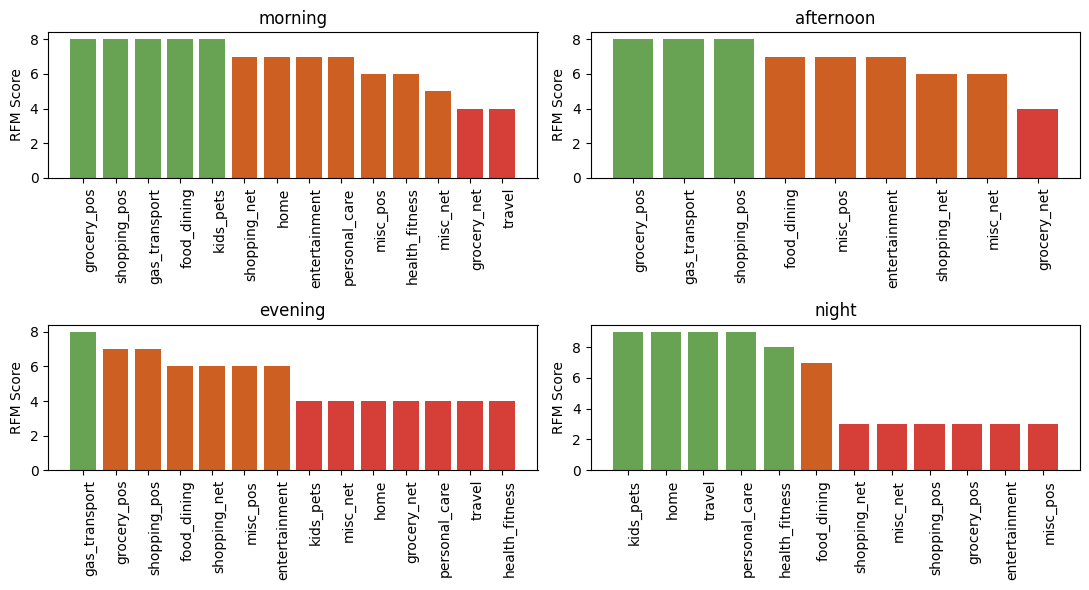

In [25]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2 , figsize=(11, 6))

# Combine all the operations and display
for idx,s in enumerate(segment_sort):
  posx = idx // h
  posy = idx % h

  rfm_segment_df = rfm_df[rfm_df[segment] == s]
  rfm_segment_top_df = rfm_segment_df.reset_index()#rfm_segment_df.nlargest(10, 'rfm', keep='all')
  rfm_segment_top_df['color'] = rfm_segment_top_df['rfm_level'].map(color)


  axis[posx, posy].bar(rfm_segment_top_df['category'],rfm_segment_top_df['rfm_score'], color = rfm_segment_top_df['color'])
  # axis[posx, posy].set_xticks(rotation=90)
  #title = f"RFM by Category and {segment_display} on {s}"
  axis[posx, posy].set_title(s)
  axis[posx, posy].set_xticklabels(rfm_segment_top_df['category'], rotation=90, ha='right', rotation_mode='anchor')
  axis[posx, posy].set_ylabel("RFM Score")


plt.tight_layout()
plt.savefig(f'{data_path}/RFM by Category and  {segment_display}.png')
plt.show()